In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import dataframe_image as dfi

### Примеры входных данных

In [3]:
# пример кода для запуска генератора данных
from data_generator.data_generator import generate_data

N = 5
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
seed = 19
data = generate_data(N, bounds_params, grid_size, seed)

In [4]:
# Пример данных для NLP постановки
# plu_line - код продуктовой линейки
# plu - код товара
# plu_idx - индекс товара
# P - текущая цена
# Q - текущие продажи в штуках
# E - эластичность
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# x_lower - нижняя граница x для диапазона поиска цены
# x_upper - верхняя граница x для диапазона поиска цены
# x_init - начальное значение x для старта оптимизатора
# dfi.export(data['data_nlp'], './images/data_nlp_sample.png')
data['data_nlp']

,plu_line_idx,P,Q,E,PC,C,plu_idx,x_lower,x_upper
0,0,141.99,0.478022,-2.455034,138.99,104.11,0,0.900000,1.100000
1,1,115.99,3.359042,-0.665581,112.99,87.67,1,0.900000,1.100000
2,1,115.99,3.359042,-0.366413,112.99,87.67,2,0.900000,1.100000
3,2,99.99,0.781950,-1.431336,91.99,73.00,3,0.900000,1.057991
4,3,51.99,3.604018,-0.841617,50.99,39.53,4,0.900000,1.100000
5,4,89.99,3.906002,-0.432880,97.99,120.56,5,0.925564,1.100000


In [5]:
# Пример данных для MILP постановки
# plu_line - код продуктовой линейки
# P - текущая цена
# PC - цена конкурента/рыночная цена
# C - себестоимость товара
# Ps - сетка цен для поиска
# Qs - сетка продаж для кажой цены из Ps
# xs - сетка индексов
# grid_size - размер сетки
# P_idx - индекс текущей цены в сетке. Если значение -1, то текщая цена не попала в сетку
# dfi.export(data['data_milp'], './images/data_milp_sample.png')
data['data_milp']

,plu_line_idx,P,PC,C,Ps,Qs,xs,grid_size,P_idx,n_plu
0,0,141.99,138.99,104.11,"[127.99, 128.99, 130.99, 131.99, 132.99, 134.9...","[0.6089394539338445, 0.5985012724198178, 0.578...","[0.9014015071483906, 0.9084442566377914, 0.922...",21,10,1
1,1,115.99,112.99,87.67,"[103.99, 105.99, 106.99, 107.99, 108.99, 109.9...","[7.08731316001623, 7.0242781667422545, 6.99298...","[0.8965428054142598, 0.9137856711785499, 0.922...",21,10,2
2,2,99.99,91.99,73.00,"[89.99, 90.99, 91.99, 92.99, 93.99, 94.99, 95....","[0.9022928650366684, 0.889468741538329, 0.8768...","[0.8999899989999, 0.90999099909991, 0.91999199...",17,10,1
3,3,51.99,50.99,39.53,"[46.99, 47.99, 48.99, 49.99, 50.99, 51.99, 52....","[3.9078585400206394, 3.8451071816875837, 3.783...","[0.9038276591652241, 0.9230621273321793, 0.942...",11,5,1
4,4,89.99,97.99,120.56,"[82.99, 83.99, 84.99, 85.99, 86.99, 87.99, 88....","[4.039764869374558, 4.020379024402288, 4.00108...","[0.9222135792865874, 0.9333259251027892, 0.944...",17,7,1


### HiGHS solver

In [6]:
df = data['data_milp']
indexes = df['grid_size'].cumsum().values
size = indexes[-1]
size



87

### Отчет по времени работы и количеству "успешно" решенных задач

In [8]:
from runner import optimizers_collect_stat

In [9]:
stats_df = optimizers_collect_stat('./data/stat/')

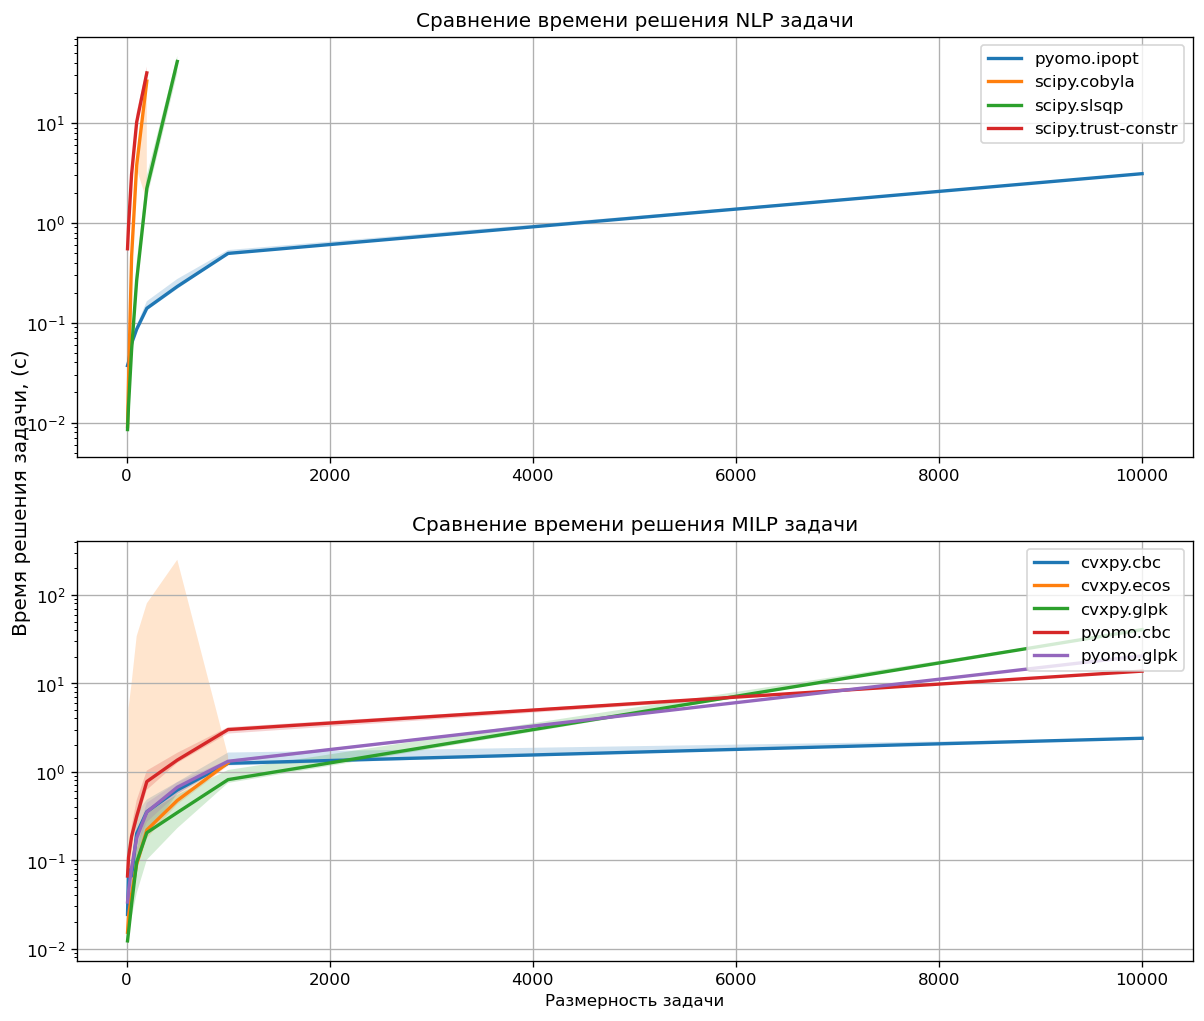

In [10]:
stats_df['success'] = stats_df['status'] == 'ok'
stats_df['opt_type'] = np.where(
    stats_df['solver'].isin(['scipy.slsqp', 'scipy.trust-constr', 'scipy.cobyla' ,'pyomo.ipopt']), 'nlp', 'lp'
)
time_rep_df = stats_df.groupby(['opt_type', 'solver', 'N'])['t'].describe().reset_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharey=False, dpi=120)
for (opt_type, solver), df in time_rep_df.groupby(['opt_type', 'solver']):
    ax_id = 0 if opt_type == 'nlp' else 1
    axes[ax_id].plot(df['N'], df['50%'], lw=2, label=solver)
    axes[ax_id].fill_between(df['N'], df['25%'], df['75%'], alpha=0.2)
axes[0].set_title('Сравнение времени решения NLP задачи')
axes[1].set_title('Сравнение времени решения MILP задачи')
# [ax.set_xscale('log') for ax in axes]
[ax.set_yscale('log') for ax in axes]
[ax.legend(loc='upper right') for ax in axes]
[ax.grid() for ax in axes]
fig.text(0.08, 0.5, 'Время решения задачи, (с)', va='center', rotation='vertical', fontdict={'size': 12})
plt.xlabel('Размерность задачи')
plt.savefig('./images/time_solve_compare.png')
plt.show()


In [10]:
success_rate_df =\
    stats_df.groupby(['solver'])['success'].mean().reset_index().rename(columns={'success': 'success_rate'})
# dfi.export(success_rate_df, './images/success_rate.png')
success_rate_df


,solver,success_rate
0,cvxpy.cbc,0.990521
1,cvxpy.ecos,0.700000
2,cvxpy.glpk,0.990521
3,pyomo.cbc,1.000000
4,pyomo.glpk,1.000000
5,pyomo.ipopt,1.000000
6,scipy.cobyla,0.513333
7,scipy.slsqp,0.955556
8,scipy.trust-constr,0.853333


### Пример запуска оптимизации(простой)

In [67]:
import numpy as np
from data_generator.data_generator import generate_data, price_round
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)


def calc_metrics(df, tp='cur'):
    sfx = ''
    if tp == 'cur':
        sfx = ''
    elif tp == 'opt':
        sfx = '_opt'
    R_ = sum(df['P' + sfx] * df['Q' + sfx])
    M_ = sum((df['P' + sfx] - df['C']) * df['Q' + sfx])
    return R_, M_


def perc_delta(v_old, v_new, ndigits=2):
    p = round(100. * (v_new / v_old - 1.), ndigits)
    sign = '+' if p >= 0 else '-'
    return sign + str(abs(p)) + '%'


bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21
#
data = generate_data(200, bounds_params, grid_size, 0)
# текущая выручка и маржа
R_cur, M_cur = calc_metrics(data['data_nlp'], 'cur')
# параметры для оптимизации
opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur,
}


"""
Тест расчёта на небольших данных
"""

res_nlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
res_milp = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')

R_opt_nlp, M_opt_nlp = calc_metrics(res_nlp['data'], 'opt')
R_opt_milp, M_opt_milp = calc_metrics(res_milp['data'], 'opt')

print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в NLP задаче'.format(
    dR=perc_delta(R_cur, R_opt_nlp), dM=perc_delta(M_cur, M_opt_nlp)))
print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в MILP задаче'.format(
    dR=perc_delta(R_cur, R_opt_milp),
    dM=perc_delta(M_cur, M_opt_milp)))

res_nlp['data']['P_opt'] = price_round(res_nlp['data']['P_opt'])
res_nlp['data']['x_opt'] = res_nlp['data']['P_opt'] / res_nlp['data']['P']
res_nlp['data']['Q_opt'] = res_nlp['data']['Q'] * np.exp(res_nlp['data']['E'] * (res_nlp['data']['x_opt'] - 1))
R_opt_nlp_ar, M_opt_nlp_ar = calc_metrics(res_nlp['data'], 'opt')

print('dR = {dR}, dM = {dM} - Изменение выручки и маржи в NLP задаче после округления'.format(
    dR=perc_delta(R_cur, R_opt_nlp_ar), dM=perc_delta(M_cur, M_opt_nlp_ar)))

ind = res_nlp['data'].groupby(['plu_line_idx'])['x_opt'].nunique().max() == 1
print(f'Все товары в линейке имеют одинаковые цены: {ind}')


dR = +7.06%, dM = +0.0% - Изменение выручки и маржи в NLP задаче
dR = +6.98%, dM = +0.0% - Изменение выручки и маржи в MILP задаче
dR = +6.98%, dM = -0.01% - Изменение выручки и маржи в NLP задаче после округления
Все товары в линейке имеют одинаковые цены: True


### Пример запуска оптимизации(сложный)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import (
    ScipyNlpOptimizationModel,
    PyomoNlpOptimizationModel,
    PyomoLpOptimizationModel,
    CvxpyLpOptimizationModel,
)

In [10]:
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
grid_size = 21

data = generate_data(100, bounds_params, 21, 4)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
#     'con_mrg': M_cur,
}

opt_params['alpha'] = 0.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_min = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

opt_params['alpha'] = 1.0
res, t =  pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
M_opt_max = sum((res['data']['P_opt'] - res['data']['C']) * res['data']['Q_opt'])

N_grid = 30
M_grid = np.linspace(M_opt_min, M_opt_max, N_grid)
R_norm_res = np.zeros(N_grid)
M_norm_res = np.zeros(N_grid)
R_res = np.zeros(N_grid)
M_res = np.zeros(N_grid)


opt_params['alpha'] = 0.0
for i, M in enumerate(M_grid):
    opt_params['con_mrg'] = M
    res, t = pricing_optimization(data, CvxpyLpOptimizationModel, opt_params, 'GLPK_MI')
    R_norm_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt']) / R_cur
    M_norm_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt']) / M_cur

    R_res[i] = sum(res['data']['P_opt']  * res['data']['Q_opt'])
    M_res[i] = sum((res['data']['P_opt'] - res['data']['C'])  * res['data']['Q_opt'])
    

ValueError: too many values to unpack (expected 2)

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_res, M_res, label='Кривая оптимальности по Парето')
plt.axvline(R_cur, ls='--', c='k', label='текущие уровни')
plt.axhline(M_cur, ls='--', c='k')
plt.scatter(R_res[0], M_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_res[-1], M_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

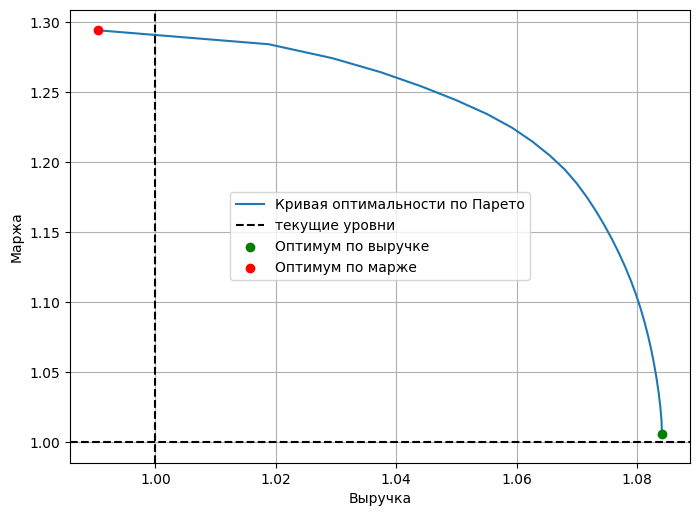

In [14]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(R_norm_res, M_norm_res, label='Кривая оптимальности по Парето')
plt.axvline(1, ls='--', c='k', label='текущие уровни')
plt.axhline(1, ls='--', c='k')
plt.scatter(R_norm_res[0], M_norm_res[0], c='g', label='Оптимум по выручке', zorder=2)
plt.scatter(R_norm_res[-1], M_norm_res[-1], c='r', label='Оптимум по марже', zorder=2)
plt.xlabel('Выручка')
plt.ylabel('Маржа')
plt.grid()
plt.legend()
plt.show()

### Запус MINLP с pyomo

In [17]:
from data_generator.data_generator import generate_data
from optimizers.optimization import pricing_optimization
from optimizers.optimizers import PyomoNlpOptimizationModel
from itertools import product

SEED_GRID = list(range(8))
N_GRID = list(range(5, 55, 5))
GRID = product(N_GRID, SEED_GRID)

bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
GRID_SIZE = 21
GRID = product(N_GRID, SEED_GRID)
minlp_stats_df_list = []

for N, seed in GRID:
    print(N, seed)
    data = generate_data(N, bounds_params, GRID_SIZE, seed)
    N_plu = len(data['data_nlp'])
    # текущая выручка и маржа
    R_cur, M_cur = calc_metrics(data['data_nlp'], 'cur')
    # параметры для оптимизации
    opt_params = {
        'alpha': 0.0,
        'con_mrg': M_cur,
        'con_chg_cnt':  int(0.7 * N_plu)
    }
    res_minlp, t_minlp = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'bonmin')
    minlp_stats_df_list.append(pd.DataFrame({
        'N': [N],
        'seed': [seed],
        't': [t_minlp],
        'status': [res_minlp['status']]
    }))
    
    print('minlp finished at %.3f' % t_minlp)
    print('--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--')
minlp_stats_df = pd.concat(minlp_stats_df_list)

minlp_stats_df.to_csv('./data/stat_minlp/stat.csv', index=None)

5 0
minlp finished at 0.346
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 1
minlp finished at 0.310
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 2
minlp finished at 0.289
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 3
minlp finished at 0.640
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 4
minlp finished at 0.722
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 5
minlp finished at 0.799
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 6
minlp finished at 0.376
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
5 7
minlp finished at 2.493
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 0
minlp finished at 1.051
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 1
minlp finished at 2.702
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
10 2
minlp finished at 3.064
--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--

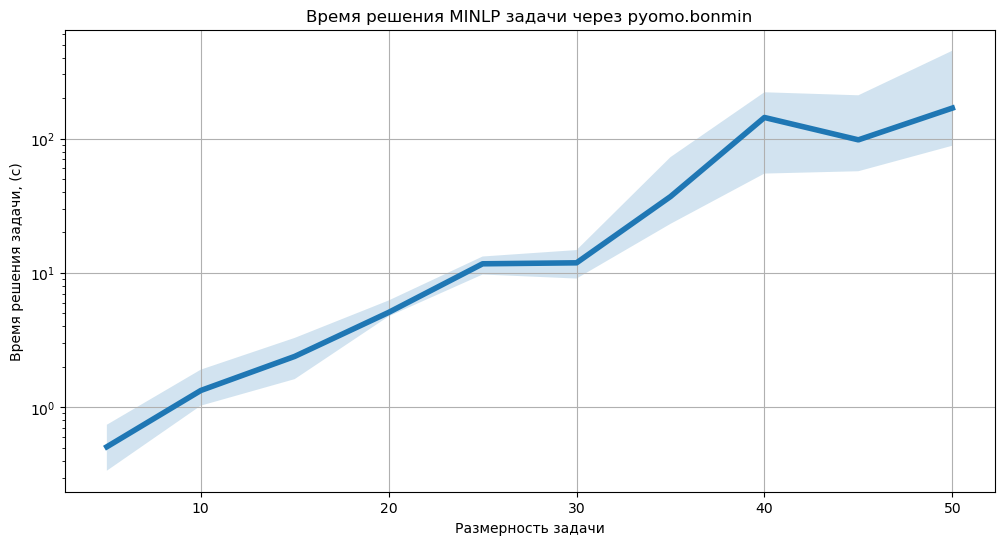

In [19]:
minlp_stats_df = pd.read_csv('./data/stat_minlp/stat.csv')
time_rep_df = minlp_stats_df.groupby(['N'])['t'].describe().reset_index()

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(time_rep_df['N'], time_rep_df['50%'], lw=4)
plt.fill_between(time_rep_df['N'], time_rep_df['25%'], time_rep_df['75%'], alpha=0.2)
# x = np.linspace(5, 30å, 100)
# y = 2.0e-1 * np.exp(0.225 * x)
# plt.plot(x, y)
plt.yscale('log')
plt.xlabel('Размерность задачи')
plt.ylabel('Время решения задачи, (с)')
plt.title('Время решения MINLP задачи через pyomo.bonmin')
plt.grid()
plt.savefig('./images/time_solve_minlp.png')
plt.show()

### Сравнение решений оптимизаторов

In [41]:
%%time
bounds_params = {
    'main_bounds': {
        'lower': 0.9, 'upper': 1.1
    },
    'market_bounds': {
        'lower': 0.85, 'upper': 1.15
    }
}
N = 500
seed = 5
grid_size = 21

data = generate_data(N, bounds_params, 21, seed)
M_cur = sum(data['data_nlp']['Q'] * (data['data_nlp']['P'] - data['data_nlp']['C']))
R_cur = sum(data['data_nlp']['Q'] * data['data_nlp']['P'])

opt_params = {
    'alpha': 0.0,
    'con_mrg': M_cur
}

CPU times: user 309 ms, sys: 2.69 ms, total: 311 ms
Wall time: 311 ms


In [62]:
np.array([[9, 8], [9, 7]]).size

4

In [42]:
%%time
try:
    res_1 = pricing_optimization(data, PyomoNlpOptimizationModel, opt_params, 'ipopt')
    print(res_1['t'], res_1['status'])
except Exception as e:
    print(e)

0.30666089057922363 ok
CPU times: user 153 ms, sys: 13 ms, total: 166 ms
Wall time: 307 ms


In [47]:
%%time
try:
    res_2 = pricing_optimization(data, ScipyNlpOptimizationModel, opt_params, 'slsqp')
    print(res_2['t'], res_2['status'])
except Exception as e:
    print(e)

12.13930606842041 ok
CPU times: user 1min 1s, sys: 842 ms, total: 1min 2s
Wall time: 12.1 s


In [48]:
df = res_1['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

120936.20702565346 111522.31767075682
23077.948812746516 23077.948952296254


In [49]:
df = res_2['data'].copy()
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)

120936.20109566531 111522.31767075682
23077.94864376093 23077.948952296254


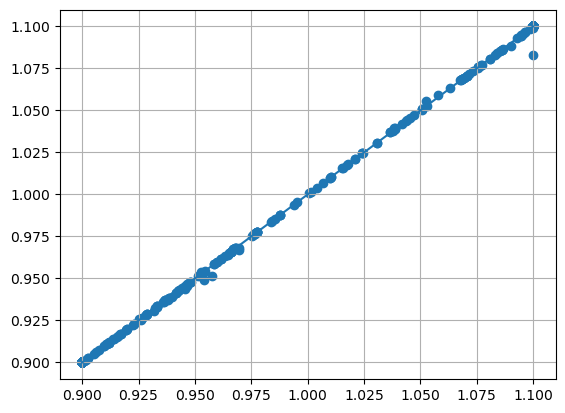

In [50]:
plt.scatter(res_1['data']['x_opt'], res_2['data']['x_opt'])
plt.plot([0.9, 1.1], [0.9, 1.1])
plt.grid()
plt.show()

### PyOptSparse

In [454]:
import pyoptsparse as pyos

In [455]:
df = data['data_nlp'].copy().sort_values('plu_idx')
plu_idx_in_line = data['plu_idx_in_line'].copy()
plu_line_idx = df['plu_line_idx'].values
plu_idx = df['plu_idx'].values
P = df['P'].values
Q = df['Q'].values
C = df['C'].values
E = df['E'].values
x_lower = df['x_lower'].values
x_upper = df['x_upper'].values

bounds = np.array([[None] * N] * 2, dtype=float)

for plu_line_idx_, plu_ in plu_idx_in_line.items():
    bounds[0][plu_line_idx_] = x_lower[plu_[0]]
    bounds[1][plu_line_idx_] = x_upper[plu_[0]]


In [456]:
def objective(x):
    x_ = x[plu_line_idx[plu_idx]]
    f = -10. * sum(P * Q * x_ * np.exp(E * (x_ - 1.))) / R_cur
    return f


In [457]:
def con_mrg(x):
    x_ = x[plu_line_idx[plu_idx]]
    f = sum((P * x_ - C) * Q * np.exp(E * (x_ - 1.)))
    return f


In [458]:
def functions(xdict):
    x = xdict['x']
    
    funcs = {}
    
    funcs['obj'] = objective(x)
    
    funcs['con_mrg'] = con_mrg(x)
        
    fails = False
    
    return funcs, fails



In [504]:
%%time
model = pyos.Optimization('', functions)

k_init = 0.5
model.addVarGroup('x', N, 'c', lower=bounds[0], upper=bounds[1], value=k_init * bounds[0] + (1-k_init) * bounds[1])

model.addObj('obj')

model.addCon('con_mrg', lower=1.0*M_cur, upper=None)


CPU times: user 1.77 ms, sys: 233 µs, total: 2 ms
Wall time: 1.77 ms


In [507]:
%%time
# opt_options = {"IPRINT": -1, 'MAXIT': 1000000, 'ACC': 1.0e-10}
# opt_options = {'file_print_level': 0, 'print_level': 0, 'sb': 'no'}
opt_options = {}

opt = pyos.OPT('conmin', options=opt_options)

CPU times: user 256 µs, sys: 3.66 ms, total: 3.91 ms
Wall time: 7.85 ms


In [508]:
%%time
sol = opt(model, sens='FD')

CPU times: user 15.9 s, sys: 313 ms, total: 16.2 s
Wall time: 16.7 s


In [509]:
df['x_opt'] = sol.xStar['x'][plu_line_idx[plu_idx]]
df

,plu_line_idx,P,Q,E,PC,C,plu_idx,x_lower,x_upper,x_opt,Q_opt,P_opt
0,0,65.99,3.660779,-4.316118,74.99,72.74,0,0.965927,1.100000,0.965927,4.240752,63.741500
1,1,161.99,1.137208,-2.657612,158.99,110.58,1,0.900000,1.100000,0.900000,1.483401,145.791000
2,1,161.99,1.137208,-0.947011,158.99,110.58,2,0.900000,1.100000,0.900000,1.250167,145.791000
3,2,80.99,3.269954,-0.023438,88.99,56.95,3,0.933961,1.100000,1.100000,3.262299,89.089000
4,2,80.99,3.269954,-0.018374,88.99,56.95,4,0.933961,1.100000,1.100000,3.263951,89.089000
...,...,...,...,...,...,...,...,...,...,...,...,...
660,496,111.99,2.175788,-2.113577,103.99,93.50,660,0.900000,1.067850,0.900000,2.687869,100.791000
661,496,111.99,2.175788,-1.094159,103.99,93.50,661,0.900000,1.067850,0.900000,2.427367,100.791000
662,497,70.99,4.032711,-0.401283,66.99,87.61,662,0.900000,1.085202,1.085202,3.897162,77.038500
663,498,131.99,0.478842,-5.098386,139.99,107.39,663,0.901519,1.100000,0.901519,0.791132,118.991500


In [510]:
df['Q_opt'] = df['Q'] * np.exp(df['E'] * (df['x_opt'] - 1))
df['P_opt'] = df['x_opt'] * df['P']
print(sum(df['P_opt'] * df['Q_opt']), R_cur)
print(sum((df['P_opt'] - df['C']) * df['Q_opt']), M_cur)


120929.72934161084 111522.31767075682
23077.947325725152 23077.948952296254


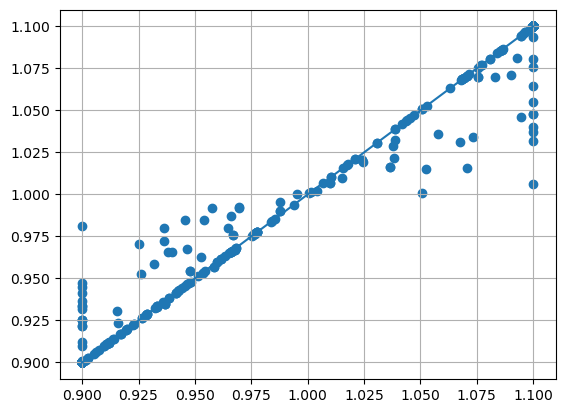

In [511]:
plt.scatter(res_1['data']['x_opt'], df['x_opt'])
plt.plot([0.9, 1.1], [0.9, 1.1])
plt.grid()
plt.show()

In [512]:
(df['x_opt'] <= df['x_upper']).mean(), (df['x_opt'] >= df['x_lower']).mean()

(1.0, 1.0)

In [513]:
sol.optInform

{}

### Тестовые примеры с pytest